Import Data starting from 2001 because the depth chart data only goes back so far.  

To do:
X  How to treat missing values in 'role' -> drop because these players were not in the depth chart before game  
- split the data for each role 

- How to handle multiple WR1 per game
    - Aggregate them per team and calculate average in points
    - Rank them based on another variable (e.g. target share, average of last games,...)

Ideas:
- Adding a model that predicts the range that a player is going to be in instead of a distinct score


In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

df_weekly = nfl.import_weekly_data(years=range(2001, 2024))
depth_charts = nfl.import_depth_charts(years=range(2001,2024))
df_schedule = nfl.import_schedules(years=range(2001,2024))
#df_weekly.head()

Downcasting floats.


In [3]:
#clean data
df_weekly = df_weekly[df_weekly['season_type'] == 'REG']
depth_charts = depth_charts[depth_charts['game_type'] == 'REG']
df_schedule = df_schedule[df_schedule['game_type'] == 'REG']

df_weekly = df_weekly.rename(columns={
    'recent_team': 'team',
    'opponent_team': 'opponent'
})

#relevant columms
rel_columns = ['player_display_name', 'player_id', 'position', 'season', 'week', 'team', 'opponent', 'fantasy_points']
#rel_columns_indiv = ['player_display_name', 'player_id', 'position', 'season', 'week', 'opponent', 'team', 'fantasy_points']

df_weekly = df_weekly[rel_columns]
df_weekly['season'] = df_weekly['season'].astype('int64')
df_weekly['week'] = df_weekly['week'].astype('int64')

df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['team']+'_'+df_weekly['opponent']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent']+'_'+df_weekly['team']

df_weekly.head()


,player_display_name,player_id,position,season,week,team,opponent,fantasy_points,game_id_home_away,game_id_away_home
0,Rabih Abdullah,00-0000007,RB,2001,15,TB,NO,0.6,2001_15_TB_NO,2001_15_NO_TB
1,Rabih Abdullah,00-0000007,RB,2001,17,TB,PHI,6.0,2001_17_TB_PHI,2001_17_PHI_TB
2,Derrick Alexander,00-0000145,WR,2001,1,KC,LV,0.0,2001_01_KC_LV,2001_01_LV_KC
3,Derrick Alexander,00-0000145,WR,2001,3,KC,WAS,6.3,2001_03_KC_WAS,2001_03_WAS_KC
4,Derrick Alexander,00-0000145,WR,2001,4,KC,DEN,3.3,2001_04_KC_DEN,2001_04_DEN_KC


In [4]:
#clean depth_charts and prepare for merge
depth_charts = depth_charts.rename(columns={ 
    'gsis_id': 'player_id'})
positions_to_keep = ['QB', 'RB', 'WR', 'TE']
depth_charts = depth_charts[depth_charts['position'].isin(positions_to_keep)]

depth_charts['role'] = depth_charts['position'] + depth_charts['depth_team']
depth_charts = depth_charts.rename(columns={ 
    'gsis_id': 'player_id'})

depth_charts['week'] = depth_charts['week'].astype(int)
depth_charts['key'] = depth_charts['season'].astype(str) + depth_charts['week'].astype(str) + depth_charts['player_id']
depth_charts = depth_charts[['season', 'week', 'player_id', 'role']]

depth_charts['season'] = depth_charts['season'].astype('int64')
depth_charts['week'] = depth_charts['week'].astype('int64')

#depth_charts.head()

In [5]:
#merge df_weekly and depth_chart 
df_merged = df_weekly.merge(
    depth_charts,
    on=['week', 'season', 'player_id'],
    how='left')
df_merged

#aggregate the fantasy points for multiple entries per role in a team and game
df_merged = (
    df_merged.groupby(['season', 'week', 'team', 'role'], as_index=False)
    .agg({
        'fantasy_points': 'mean',  # Aggregating fantasy points
        'opponent': 'first',       # Keep the first value of opponent for each group
        'player_id': 'first',      
        'opponent': 'first',
        'position': 'first',
        'game_id_home_away': 'first',
        'game_id_away_home': 'first'
      
    })
)

print(df_merged)

       season  week team role  fantasy_points opponent   player_id position  \
0        2001     1  BUF  RB1        0.300000       NO  00-0019484       RB   
1        2001     1  BUF  TE1        1.600000       NO  00-0013728       TE   
2        2001     1  BUF  WR1        6.300000       NO  00-0013232       WR   
3        2001     1  CAR  QB1       16.620001      MIN  00-0020434       QB   
4        2001     1  CAR  RB1        1.900000      MIN  00-0001224       RB   
...       ...   ...  ...  ...             ...      ...         ...      ...   
86644    2023    18  WAS  TE1        0.900000      DAL  00-0031260       TE   
86645    2023    18  WAS  TE2        0.000000      DAL  00-0036628       TE   
86646    2023    18  WAS  WR1        2.775000      DAL  00-0031941       WR   
86647    2023    18  WAS  WR2        0.673333      DAL  00-0036626       WR   
86648    2023    18  WAS  WR3        0.800000      DAL  00-0031941       WR   

      game_id_home_away game_id_away_home  
0      

In [6]:
#clean df_schedule
relevant_columns = ['season','week','home_team','away_team','home_score','away_score','location',
                           'spread_line','roof','surface','home_coach','away_coach','stadium','game_id']
df_schedule = df_schedule[relevant_columns]

#df_schedule.head()


In [7]:
#merge df_schedule with df_merge
df_merged = pd.melt(
    df_merged,
    id_vars=['player_id', 'position', 'season', 'week','team', 'opponent', 'fantasy_points','role'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id')

df_merged = pd.merge(df_merged, 
                     df_schedule[relevant_columns], 
                     on= 'game_id',
                     how='inner')

df_merged = df_merged.rename(columns={
    'season_x': 'season',
    'week_x': 'week'
})
df_merged = df_merged.drop(['season_y','week_y'], axis=1)

#df_merged.head()

In [8]:
#Additional df for team performance measurements
#load csv file
file_path = "/Users/alexanderarens/Desktop/data_science_project/data/games.csv"  
df = pd.read_csv(file_path) 
df = df[df['game_type'] == 'REG']

# Inspect the home team DataFrame
home_df = df[['game_id','season','week','gameday','home_team','home_score','away_team','away_score']].rename(
    columns={'home_team': 'team', 'home_score': 'points_scored', 'away_team': 'opponent', 'away_score': 'points_allowed'}
).assign(location='home')

# Inspect the away team DataFrame
away_df = df[['game_id', 'season', 'week', 'gameday', 'away_team', 'away_score', 'home_team', 'home_score']].rename(
    columns={'away_team': 'team', 'away_score': 'points_scored', 'home_team': 'opponent', 'home_score': 'points_allowed'}
).assign(location='away')

# Concatenate vertically
df_combined = pd.concat([home_df, away_df], ignore_index=True)
df_combined = df_combined.sort_values(by=['season', 'week','team'])
df_combined.head()

df_combined = df_combined.sort_values(by=['team', 'season', 'week'])

# Rolling average for points scored (offense)
df_combined['rolling_avg_points_scored'] = (
    df_combined.groupby('team')['points_scored']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(drop=True))

# Rolling average for points allowed (defense)
df_combined['rolling_avg_points_allowed'] = (
    df_combined.groupby('team')['points_allowed']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(drop=True))

# Offense rank: Higher points scored -> Better rank
df_combined['offense_rank'] = (
    df_combined.groupby(['season', 'week'])['rolling_avg_points_scored']
    .rank(ascending=False, method='min')
)

# Defense rank: Lower points allowed -> Better rank
df_combined['defense_rank'] = (
    df_combined.groupby(['season', 'week'])['rolling_avg_points_allowed']
    .rank(ascending=True, method='min')
)

In [9]:
#merge with the rest
df_merged = pd.merge(
    df_merged,
    df_combined[['season','week','team','points_allowed', 'points_scored', 'rolling_avg_points_scored', 'rolling_avg_points_allowed', 'offense_rank', 'defense_rank']],
    on=['season', 'week', 'team'],
    how='left')

# Create the dummy variable for home games
df_merged['is_home_game'] = (df_merged['home_team'] == df_merged['team']).astype(int)

# create column 'coach'
df_merged['coach'] = np.where(df_merged['is_home_game'], df_merged['home_coach'], df_merged['away_coach'])
#df_merged

In [10]:
#drop missing values = players that were not on the depth chart
df_merged = df_merged.dropna(subset=['role'])

#final seleciton of features
df_pred = df_merged[['role','season','week','team','opponent','spread_line','roof', 'coach', 'is_home_game','offense_rank','defense_rank','rolling_avg_points_allowed','rolling_avg_points_scored','fantasy_points',]]

# Extract the position from the 'role' column
df_pred['position'] = df_pred['role'].str.extract(r'([A-Z]+)')
# Create separate DataFrames for each position
df_qb = df_pred[df_pred['position'] == 'QB']  # Quaterbacks
df_qb = df_qb.drop(columns=['position'])
df_wr = df_pred[df_pred['position'] == 'WR']  # Wide Receivers
df_wr = df_wr.drop(columns=['position'])
df_rb = df_pred[df_pred['position'] == 'RB']  # Running Backs
df_rb = df_rb.drop(columns=['position'])
df_te = df_pred[df_pred['position'] == 'TE']  # Tight Ends
df_te = df_te.drop(columns=['position'])
df_pred = df_pred.drop(columns=['position'])

#one-hot-encoding for categorical variables
df_pred = pd.get_dummies(df_pred, columns=['team', 'role', 'opponent', 'roof', 'coach'], drop_first=True)
df_qb = pd.get_dummies(df_qb, columns=['team', 'role', 'opponent', 'roof', 'coach'], drop_first=True)
df_wr = pd.get_dummies(df_wr, columns=['team', 'role', 'opponent', 'roof', 'coach'], drop_first=True)
df_rb = pd.get_dummies(df_rb, columns=['team', 'role', 'opponent', 'roof', 'coach'], drop_first=True)
df_te = pd.get_dummies(df_te, columns=['team', 'role', 'opponent', 'roof', 'coach'], drop_first=True)

/var/folders/f8/sj2vh6pn2550v8b3lybk3zbw0000gn/T/ipykernel_7442/3530387607.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['position'] = df_pred['role'].str.extract(r'([A-Z]+)')


In [11]:
df_pred

,season,week,spread_line,is_home_game,offense_rank,defense_rank,rolling_avg_points_allowed,rolling_avg_points_scored,fantasy_points,team_ATL,...,coach_Todd Bowles,coach_Todd Haley,coach_Tom Coughlin,coach_Tony Dungy,coach_Tony Sparano,coach_Urban Meyer,coach_Vance Joseph,coach_Vic Fangio,coach_Wade Phillips,coach_Zac Taylor
0,2001,1,10.0,0,3.0,25.0,26.6,27.8,16.620001,0,...,0,0,0,0,0,0,0,0,0,0
1,2001,1,10.0,0,3.0,25.0,26.6,27.8,1.900000,0,...,0,0,0,0,0,0,0,0,0,0
2,2001,1,10.0,0,3.0,25.0,26.6,27.8,7.400000,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,1,10.0,0,3.0,25.0,26.6,27.8,3.700000,0,...,0,0,0,0,0,0,0,0,0,0
4,2001,1,10.0,0,3.0,25.0,26.6,27.8,7.350000,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75818,2005,3,-3.5,1,17.0,21.0,23.2,23.0,2.800000,0,...,0,0,0,0,0,0,0,0,0,0
75819,2005,3,-3.5,1,17.0,21.0,23.2,23.0,7.800000,0,...,0,0,0,0,0,0,0,0,0,0
75820,2005,3,-3.5,1,17.0,21.0,23.2,23.0,4.450000,0,...,0,0,0,0,0,0,0,0,0,0
75821,2005,3,-3.5,1,17.0,21.0,23.2,23.0,0.833333,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Linear regression
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error: 18.49
Root Mean Squared Error: 4.30
R-squared: 0.11
                       Feature  Coefficient  Absolute Coefficient
125           coach_Giff Smith    -8.515022              8.515022
120     coach_Eric Studesville    -7.462813              7.462813
136        coach_Jeff Saturday    -6.082828              6.082828
103           coach_Dave Campo    -6.007716              6.007716
124       coach_George Seifert    -5.656873              5.656873
..                         ...          ...                   ...
1                         week    -0.006404              0.006404
4                 offense_rank     0.005075              0.005075
7    rolling_avg_points_scored     0.004171              0.004171
72                   roof_dome    -0.002951              0.002951
2                  spread_line    -0.001599              0.001599

[220 rows x 3 columns]


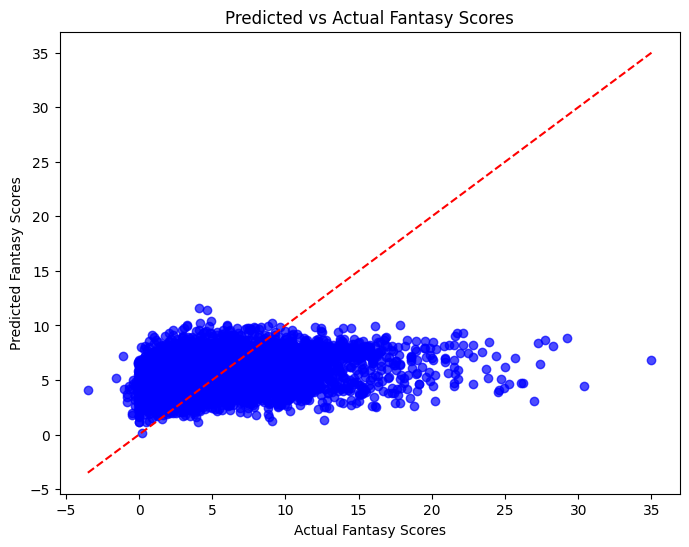

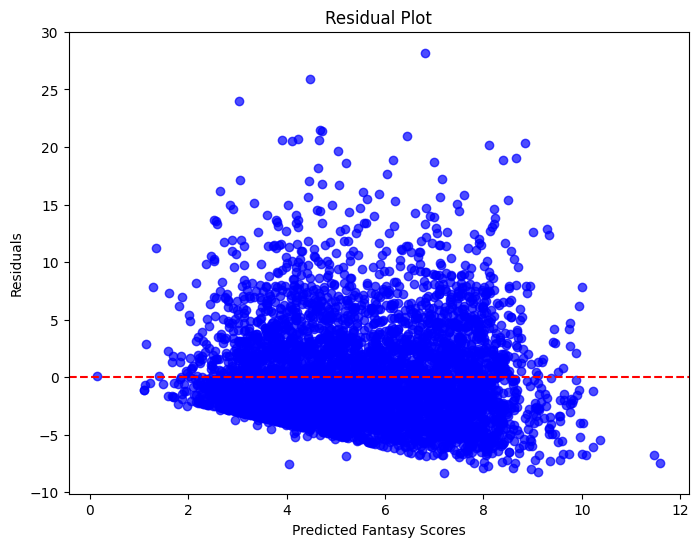

In [13]:
# Define feature columns (X) and target (y)
X = df_wr.drop(columns=['fantasy_points'])
y = df_wr['fantasy_points']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Linear Regression for simplicity)
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients and feature names
coefficients = model.coef_
feature_names = X.columns

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
#MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

#RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

#R2
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

#coefficients
# Create a dataframe to display the features and their corresponding coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients (to see the most impactful features)
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the results
print(coeff_df)

#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('Actual Fantasy Scores')
plt.ylabel('Predicted Fantasy Scores')
plt.title('Predicted vs Actual Fantasy Scores')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Line for zero residuals
plt.xlabel('Predicted Fantasy Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Random Forest MSE: 18.92
Random Forest R²: 0.09


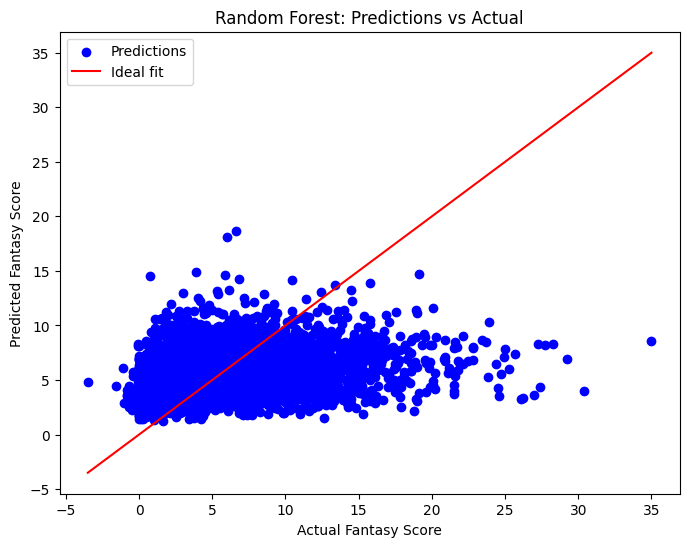

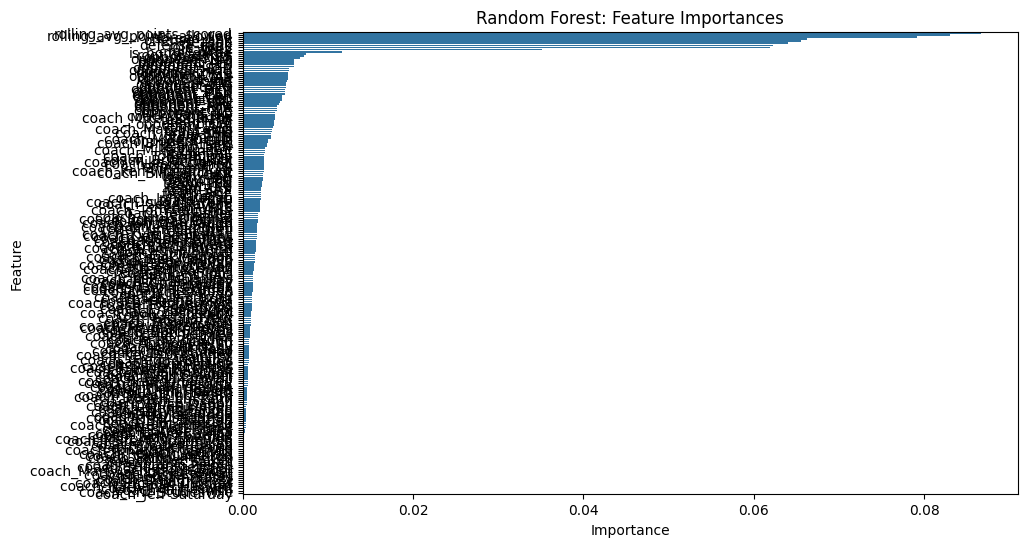

In [14]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal fit')
plt.title('Random Forest: Predictions vs Actual')
plt.xlabel('Actual Fantasy Score')
plt.ylabel('Predicted Fantasy Score')
plt.legend()
plt.show()

# Visualize feature importances
features = X_train.columns
importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest: Feature Importances')
plt.show()

In [16]:
#XG Boost
import xgboost as xgb

# Initialize and train the model
gbm_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gbm = gbm_model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_gbm)
mae = mean_absolute_error(y_test, y_pred_gbm)
r2 = r2_score(y_test, y_pred_gbm)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 18.06
Mean Absolute Error (MAE): 3.19
R-squared (R2): 0.13


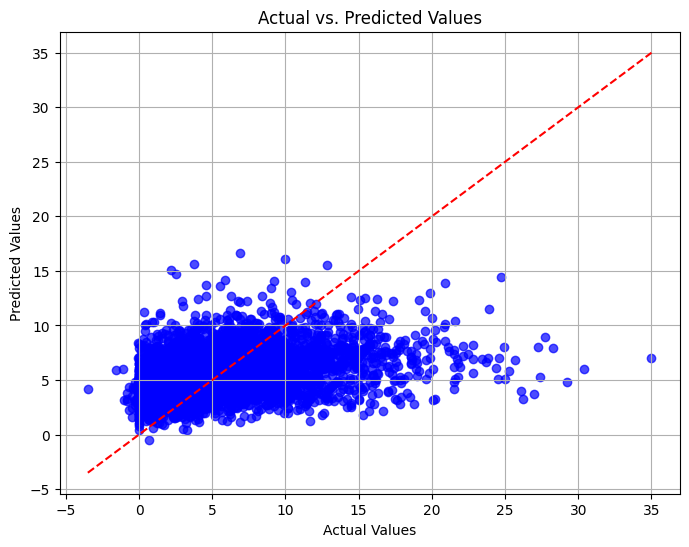

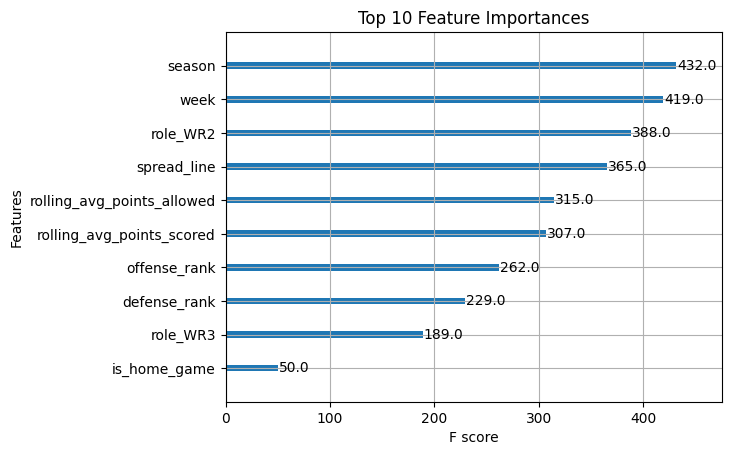

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gbm, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

# Plot feature importance
xgb.plot_importance(gbm_model, importance_type='weight', max_num_features=10, title="Top 10 Feature Importances")
plt.show()


------------------------------------------------------------------------

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/nfl-team-stats-and-outcomes")

print("Path to dataset files:", path)

In [ ]:
# Calculate the offense and defense ranks
# Import weekly data from 2001 onwards
df_weekly = nfl.import_weekly_data(years=list(range(2001, 2023)), columns=[
    'week', 'team', 'opponent', 'points_scored', 'points_allowed',
    'total_yards', 'total_yards_allowed'])

# Sort data by team and week
df_weekly = df_weekly.sort_values(by=['team', 'week'])

# Calculate rolling stats (last 5 games)
df_weekly['rolling_total_yards'] = df_weekly.groupby('team')['total_yards'].rolling(window=5, min_periods=1).mean().reset_index(drop=True)
df_weekly['rolling_total_yards_allowed'] = df_weekly.groupby('team')['total_yards_allowed'].rolling(window=5, min_periods=1).mean().reset_index(drop=True)

# Rank teams based on rolling stats
df_weekly['offense_rank'] = df_weekly.groupby('week')['rolling_total_yards'].rank(ascending=False)
df_weekly['defense_rank'] = df_weekly.groupby('week')['rolling_total_yards_allowed'].rank(ascending=True)



In [ ]:
Target_columns = ["week, season, team, role, opponent, home game, offence_rank, opponent_rank, red_zone_attemps, possession_time, fantasy points, ]
weekly_columns = ["week, season, team, opponent, fantasy points"]                 

In [ ]:
roster = nfl.import_weekly_rosters(years=[2002])
roster.info()
